<a href="https://colab.research.google.com/github/sayanghorui/samplecode/blob/master/advanced_usage_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspect the Temparature data:

In [1]:
from google.colab import drive
drive.mount('Mydrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at Mydrive


In [0]:
data_path ='Mydrive/My Drive/ML_datasets/jena_climate_2009_2016.csv'

f = open(data_path)
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Parse data:

In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

Temparature timeseries plot:

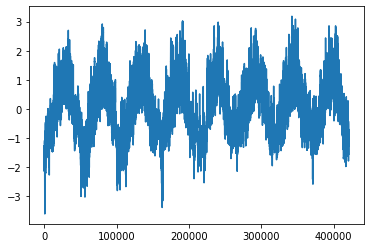

In [24]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] 
plt.plot(range(len(temp)), temp)
plt.show()

Plotting first 10 days of Temparature timeseries:

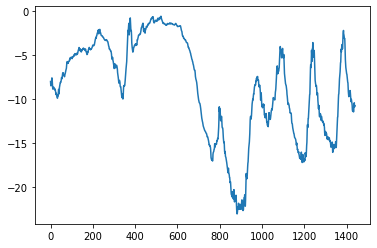

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

Normalize the data:

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
float_data[100938:100940]

array([[-1.31789941, -2.35948615, -2.24570203, -2.48380129,  0.76796186,
        -1.41926761, -1.69766953, -0.78422463, -1.68634755, -1.68981715,
         1.99124518,  0.54598535,  0.46359608, -1.76528498],
       [-1.31672023, -2.35383802, -2.24011747, -2.49077883,  0.72611414,
        -1.41796708, -1.69766953, -0.78009269, -1.68634755, -1.68981715,
         1.985832  ,  0.82581221,  1.01279367, -1.81897192]])

Generator function:

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Training, Validation and Test Generator:

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,max_index=200000,shuffle=True,step=step,batch_size=batch_size)
val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,max_index=None,step=step,batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
for data_batch, labels_batch in train_gen:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break
print(data_batch[0][-1][1])
print(labels_batch[0])

data batch shape: (128, 240, 14)
labels batch shape: (128,)
0.10083605112079307
0.26237235705214296


Non Machine Learning Baseline:

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    mae = np.mean(batch_maes)
    print('mae:',mae)
    print('Temp diff in Celsius:', (std[1] * mae))

In [30]:
evaluate_naive_method()

mae: 0.2897359729905486
Temp diff in Celsius: 2.564887434980494


Basic Machine Learning model with Densely Coonected layers:

In [31]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________




Epoch 1/20





500/500 [==============================] - 21s 42ms/step - loss: 0.9756 - val_loss: 0.4344
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3292 - val_loss: 0.3204
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2794 - val_loss: 0.3492
Epoch 4/20
500/500 [==============================] - 11s 21

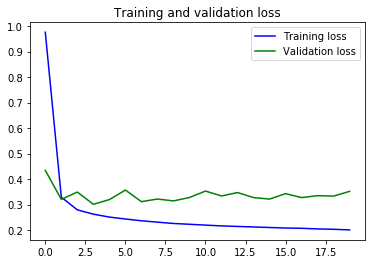

In [32]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

A Recurrent Baseline Model:

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 156s 311ms/step - loss: 0.3027 - val_loss: 0.2836
Epoch 2/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2847 - val_loss: 0.2678
Epoch 3/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2786 - val_loss: 0.2641
Epoch 4/20
500/500 [==============================] - 153s 305ms/step - loss: 0.2739 - val_loss: 0.2662
Epoch 5/20
500/500 [==============================] - 153s 305ms/step - loss: 0.2695 - val_loss: 0.2642
Epoch 6/20
500/500 [==============================] - 152s 303ms/step - loss: 0.2648 - val_loss: 0.2645
Epoch 7/20
500/500 [==============================] - 151s 302ms/step - loss: 0.2597 - val_loss: 0.2699
Epoch 8/20
500/500 [==============================] - 153s 307ms/step - loss: 0.2537 - val_loss: 0.2674
Epoch 9/20
500/500 [==============================] - 153s 307ms/step - lo

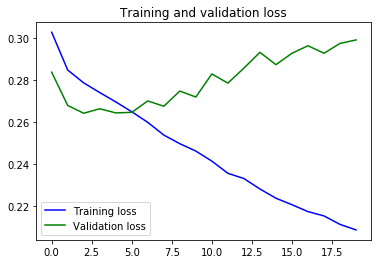

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Using Recurrent Dropout to fight Overfitting:

In [33]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=40,validation_data=val_gen,validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/40
500/500 [==============================] - 176s 352ms/step - loss: 0.3374 - val_loss: 0.2744
Epoch 2/40
500/500 [==============================] - 174s 348ms/step - loss: 0.3146 - val_loss: 0.2701
Epoch 3/40
500/500 [==============================] - 174s 349ms/step - loss: 0.3075 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 173s 345ms/step - loss: 0.3042 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 172s 344ms/step - loss: 0.2974 - val_loss: 0.2666
Epoch 6/40
500/500 [==============================] - 172s 343ms/step - loss: 0.2973 - val_loss: 0.2683
Epoch 7/40
500/500 [==============================] - 173s 346ms/step - loss: 0.2941 - val_loss: 0.2650
Epoch 8/40
500/500 [==============================] - 173s 347

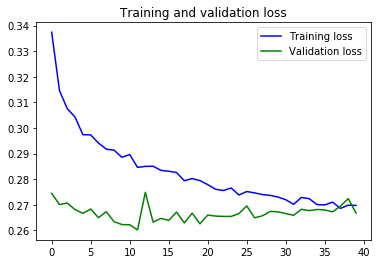

In [34]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()